<a href="https://colab.research.google.com/github/pedro-pauletti/deeplearning-pytorch/blob/main/Convolution_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Transforms

In [34]:
!pip3 install torch torchvision

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [37]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [56]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().cpu().numpy()
    image = image.reshape((28, 28))
    image = image * 0.5 + 0.5
    return image


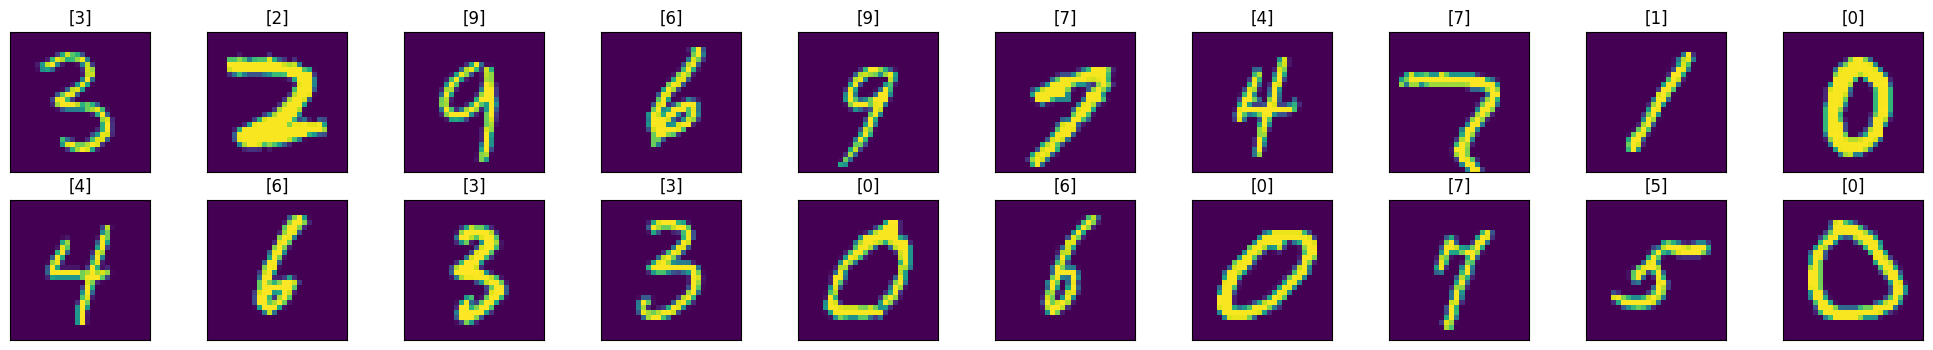

In [57]:
dataiter = iter(training_loader)
images, labels = next(dataiter)  # Fetch the next batch using the next() function

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

### Neural Network Implementation

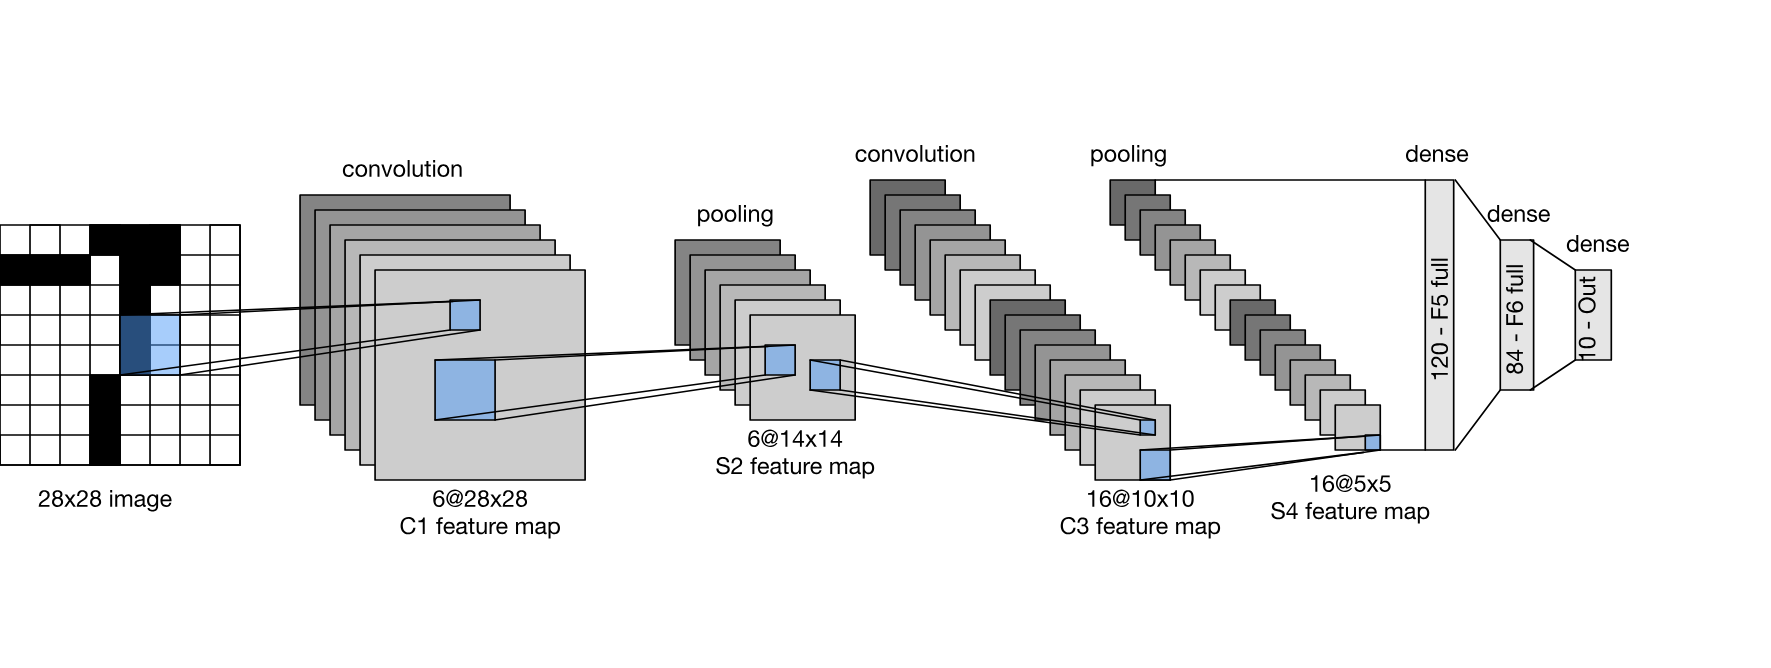

In [40]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [41]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [43]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)


    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: ', (e+1))
    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 0.0058, accuracy: 0.8485
validation loss: 0.0018, validation accuracy: 0.9482
epoch:  2
training loss: 0.0015, accuracy: 0.9556
validation loss: 0.0011, validation accuracy: 0.9686
epoch:  3
training loss: 0.0010, accuracy: 0.9711
validation loss: 0.0007, validation accuracy: 0.9761
epoch:  4
training loss: 0.0008, accuracy: 0.9769
validation loss: 0.0006, validation accuracy: 0.9806
epoch:  5
training loss: 0.0006, accuracy: 0.9811
validation loss: 0.0006, validation accuracy: 0.9811
epoch:  6
training loss: 0.0006, accuracy: 0.9833
validation loss: 0.0005, validation accuracy: 0.9845
epoch:  7
training loss: 0.0005, accuracy: 0.9852
validation loss: 0.0004, validation accuracy: 0.9853
epoch:  8
training loss: 0.0004, accuracy: 0.9864
validation loss: 0.0004, validation accuracy: 0.9870
epoch:  9
training loss: 0.0004, accuracy: 0.9875
validation loss: 0.0004, validation accuracy: 0.9875
epoch:  10
training loss: 0.0004, accuracy: 0.9891
validation loss: 0.000

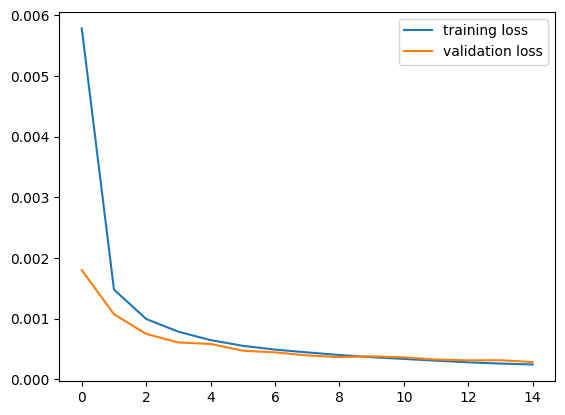

In [44]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

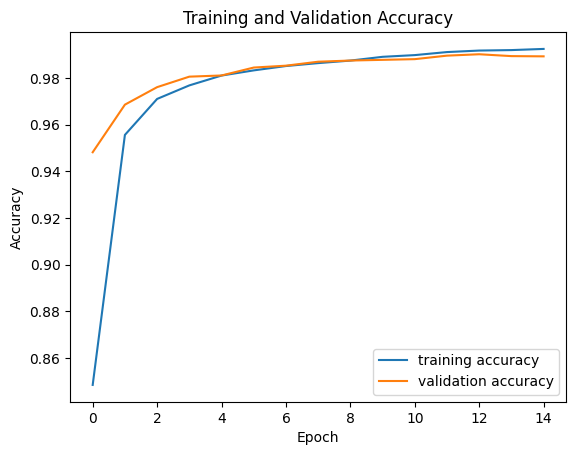

In [58]:
# Convert the tensors to CPU (host) before plotting
running_corrects_history_cpu = [t.item() for t in running_corrects_history]
val_running_corrects_history_cpu = [t.item() for t in val_running_corrects_history]

plt.plot(running_corrects_history_cpu, label='training accuracy')
plt.plot(val_running_corrects_history_cpu, label='validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Final Tests

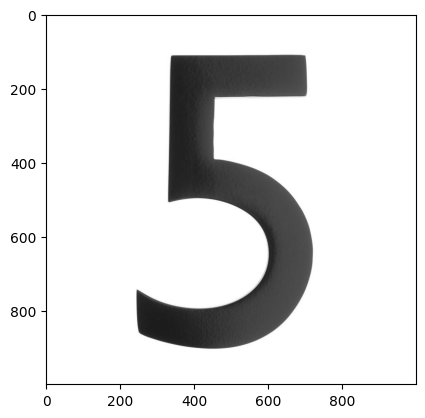

In [59]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

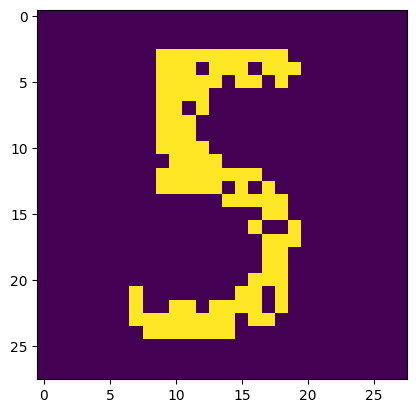

In [60]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [61]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


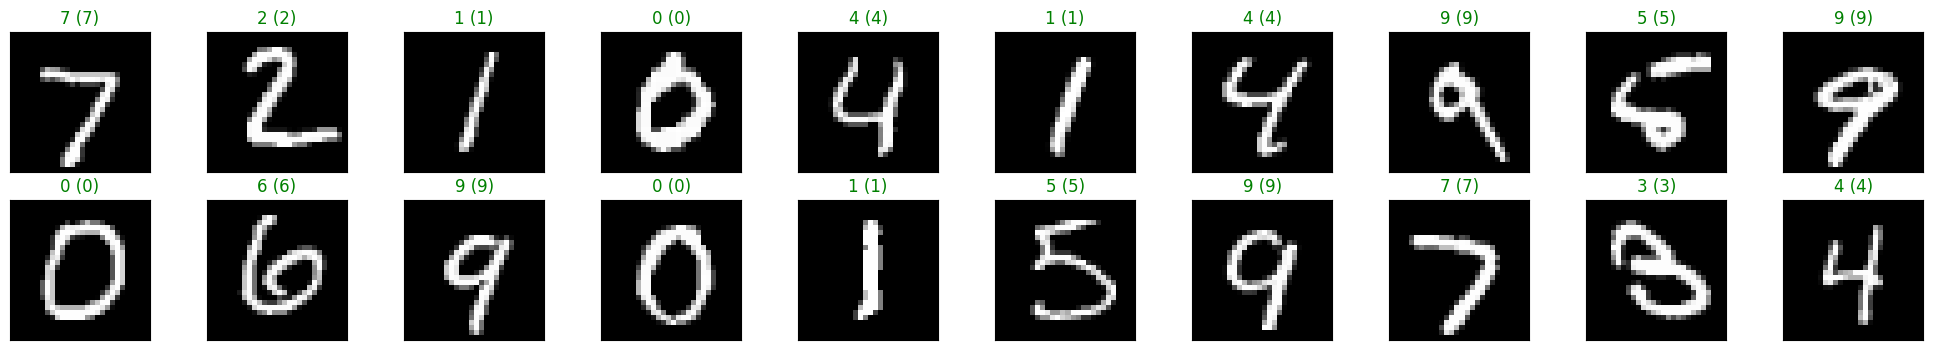

In [62]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),color = ("green" if preds[idx]==labels[idx] else "red") )